In [1]:
import os, glob, cv2, time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
#preprocessing
def normalize_depth(depth_img):
    depth = np.array(depth_img).astype(np.float32)
    d_min, d_max = depth.min(), depth.max()
    if d_max - d_min < 1e-8:
        return np.zeros_like(depth)
    return (depth - d_min) / (d_max - d_min)

def process_grasps(grasps, max_grasps=8):
    fixed = torch.zeros((max_grasps, 4, 2), dtype=torch.float32)
    if len(grasps) == 0:
        return fixed
    grasps = [torch.tensor(g, dtype=torch.float32) for g in grasps[:max_grasps]]
    for i, g in enumerate(grasps):
        fixed[i] = g
    return fixed

In [10]:

class CornellGraspDataset(Dataset):
    def __init__(self, root_dir, target_size=(224,224), max_grasps=8):
        self.root_dir = root_dir
        self.target_size = target_size
        self.max_grasps = max_grasps
        self.samples = []

        # collect only valid samples
        for folder in sorted(os.listdir(root_dir)):
            if folder == 'backgrounds':
                continue
            folder_path = os.path.join(root_dir, folder)
            for rgb_file in glob.glob(os.path.join(folder_path, '*r.png')):
                base = rgb_file.replace('r.png', '')
                depth_file = base + 'd.tiff'
                pos_file = base + 'cpos.txt'
                if os.path.exists(depth_file) and os.path.exists(pos_file):
                    self.samples.append((rgb_file, depth_file, pos_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rgb_file, depth_file, pos_file = self.samples[idx]

        # load rgb
        rgb = np.array(Image.open(rgb_file).convert('RGB')).astype(np.float32) / 255.0

        #load depth
        depth = np.array(Image.open(depth_file).convert('L')).astype(np.float32)

        # normalize depth
        d_min, d_max = depth.min(), depth.max()
        if d_max - d_min > 1e-8:
            depth = (depth - d_min) / (d_max - d_min)
        else:
            depth = np.zeros_like(depth)

        # resize
        h, w = self.target_size
        rgb = cv2.resize(rgb, (w,h))
        depth = cv2.resize(depth, (w,h))

        # stack
        rgbd = np.dstack((rgb, depth[...,None]))
        rgbd_tensor = torch.from_numpy(rgbd.transpose(2,0,1)).float()

        # normalize
        rgbd_tensor = (rgbd_tensor - 0.5) / 0.5
        rgbd_tensor = torch.clamp(rgbd_tensor, -1.0, 1.0)

        # pos
        grasps = []
        
        with open(pos_file, 'r') as f:
            lines = f.readlines()
            for i in range(0, len(lines), 4):
                rect = [list(map(float, line.strip().split())) for line in lines[i:i+4]]
                grasps.append(np.array(rect, dtype=np.float32))

        if len(grasps) > 0:
            grasps_np = np.array(grasps[:self.max_grasps], dtype=np.float32)
            grasps_tensor = process_grasps(grasps, self.max_grasps)
        else:
            grasps_tensor = torch.zeros((self.max_grasps,4,2), dtype=torch.float32)
            

        return rgbd_tensor, grasps_tensor, rgb

In [11]:

#transform

class ToTensor4D:
    def __call__(self, sample):
        t = torch.from_numpy(sample.transpose(2, 0, 1)).float()
        return t

transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5, 0.5])
])



Total samples: 885


In [ ]:
#load data

root_dir = 'archive'
dataset = CornellGraspDataset(root_dir)



In [ ]:
#split train/test

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


print(len(dataset))

In [12]:
def visualize_data(dataset, indices, transform=None, max_grasps=8):

    batch_size = len(indices)
    fig, axes = plt.subplots(batch_size, 2, figsize=(8, 4*batch_size))

    if batch_size == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(indices):
        # get data from dataset
        transformed_img, grasps, original_rgb = dataset[idx]

        # load original PIL image
        # RGB path
        orig_path = dataset.samples[idx][0]  
        pil_image = Image.open(orig_path).convert('RGB')
        
        W_orig, H_orig = pil_image.size

        # process to fixed size
        if grasps.shape[0] != max_grasps:
            fixed_grasps = torch.zeros((max_grasps, 4, 2))
            n = min(grasps.shape[0], max_grasps)
            fixed_grasps[:n] = grasps[:n]
            grasps = fixed_grasps

        # original
        ax_orig = axes[i,0]
        ax_orig.imshow(pil_image)
        ax_orig.set_title("Original")
        ax_orig.axis('off')
        for grasp in grasps:
            if torch.sum(grasp) == 0:
                continue
            rect = grasp.numpy()
            rect = np.vstack([rect, rect[0]])  # close rectangle
            ax_orig.plot(rect[:,0], rect[:,1], 'r-', linewidth=2)

        # transformed
        img = transformed_img
        if isinstance(img, torch.Tensor):
            img = img.permute(1,2,0).numpy()
            img = (img*255).astype(np.uint8)
        H, W = img.shape[:2]

        ax_tr = axes[i,1]
        ax_tr.imshow(img)
        ax_tr.set_title("Transformed")
        ax_tr.axis('off')
        for grasp in grasps:
            if torch.sum(grasp) == 0:
                continue
            rect = grasp.numpy()
            # scale to transformed image size
            rect[:,0] = rect[:,0] * (W / W_orig)
            rect[:,1] = rect[:,1] * (H / H_orig)
            rect = np.vstack([rect, rect[0]])
            ax_tr.plot(rect[:,0], rect[:,1], 'r-', linewidth=2)

    plt.tight_layout()
    plt.show()

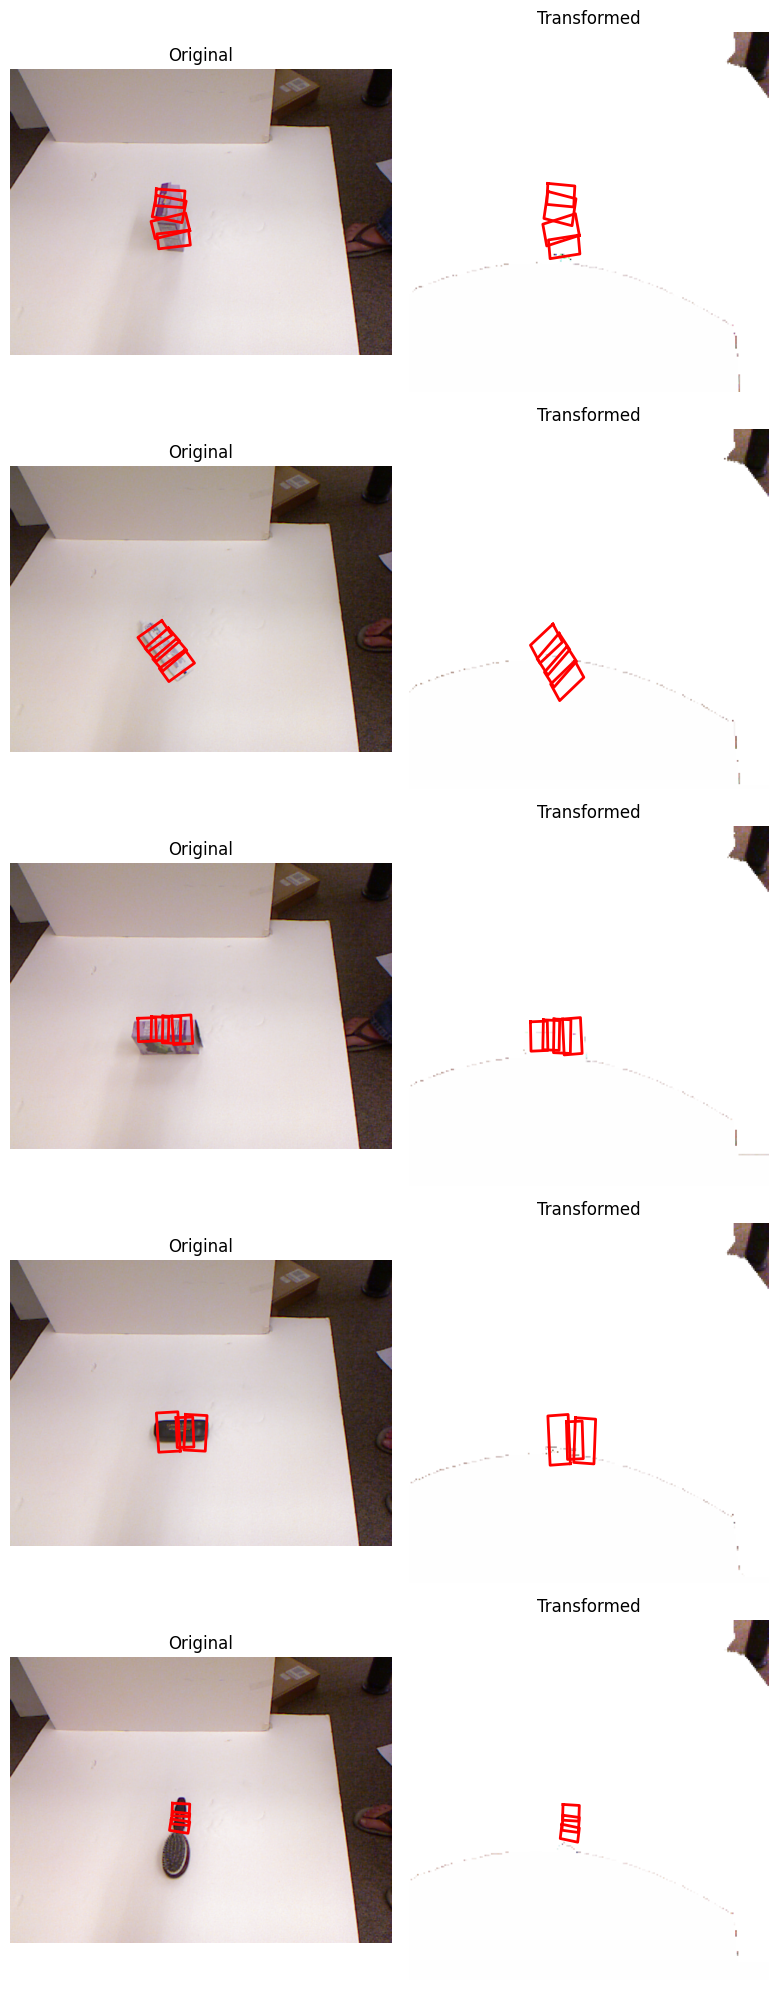

In [13]:

# visualize 5 examples from the dataset
indices_to_show = [0, 5, 10, 20, 30]
visualize_data(dataset, indices_to_show, transform=transform)

In [14]:
#baseline CNN
class GRConvNet(nn.Module):
    def __init__(self):
        super(GRConvNet, self).__init__()
        self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        self.backbone.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 4)  # x, y, width, angle

    def forward(self, x):
        return self.backbone(x)

In [15]:
#train grconvnet model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRConvNet().to(device)

criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 15
img_size = 224 

#training start
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_pixel_error = 0.0

    for images, grasps, _ in train_loader:
        images = images.to(device)

        # calculate normalized centers
        centers = []
        for g in grasps:
            if g.numel() == 0:
                c = torch.zeros(4, device=device)
            else:
                c_xy = g.mean(dim=(0,1)) / img_size  # normalize x,y
                temp_wh = torch.zeros(2, device=device)  # temp width and height
                c = torch.cat([c_xy, temp_wh])
            centers.append(c)
        centers = torch.stack(centers)

        # Nan handling
        if torch.isnan(images).any() or torch.isnan(centers).any():
            print("NaN")
            continue

        optimizer.zero_grad()
        outputs = model(images)

        loss = criteria(outputs, centers)
        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

        # mse
        pixel_error = torch.norm((outputs[:, :2] - centers[:, :2]) * img_size, dim=1).mean()
        running_pixel_error += pixel_error.item()

    avg_loss = running_loss / len(train_loader)
    avg_pixel_error = running_pixel_error / len(train_loader)
    curr_epoch = epoch+1
    print(f"Epoch {curr_epoch} Loss: {avg_loss}, Mean Pixel Error: {avg_pixel_error}")


NaN detected! Skipping batch.
Epoch [1/15] Loss: 0.0903, Mean Pixel Error: 102.17
NaN detected! Skipping batch.
Epoch [2/15] Loss: 0.0415, Mean Pixel Error: 75.37
NaN detected! Skipping batch.
Epoch [3/15] Loss: 0.0344, Mean Pixel Error: 67.91
NaN detected! Skipping batch.
Epoch [4/15] Loss: 0.0307, Mean Pixel Error: 64.15
NaN detected! Skipping batch.
Epoch [5/15] Loss: 0.0241, Mean Pixel Error: 56.43
NaN detected! Skipping batch.
Epoch [6/15] Loss: 0.0205, Mean Pixel Error: 51.95
NaN detected! Skipping batch.
Epoch [7/15] Loss: 0.0205, Mean Pixel Error: 51.88
NaN detected! Skipping batch.
Epoch [8/15] Loss: 0.0150, Mean Pixel Error: 44.32
NaN detected! Skipping batch.
Epoch [9/15] Loss: 0.0111, Mean Pixel Error: 38.56
NaN detected! Skipping batch.
Epoch [10/15] Loss: 0.0112, Mean Pixel Error: 38.32
NaN detected! Skipping batch.
Epoch [11/15] Loss: 0.0100, Mean Pixel Error: 36.05
NaN detected! Skipping batch.
Epoch [12/15] Loss: 0.0081, Mean Pixel Error: 32.97
NaN detected! Skipping b

In [16]:
#evaluate model
model.eval()
test_loss = 0.0
test_pixel_error = 0.0
with torch.no_grad():
    for images, grasps, _ in test_loader:
        images = images.to(device)


        # calculate normalized centers
        centers = []
        for g in grasps:
            if g.numel() == 0:
                c = torch.zeros(4, device=device)
            else:
                c_xy = g.mean(dim=(0,1)) / img_size
                temp_wh = torch.zeros(2, device=device)
                c = torch.cat([c_xy, temp_wh])
            centers.append(c)
            
        centers = torch.stack(centers)

        outputs = model(images)
        loss = criteria(outputs, centers)
        test_loss += loss.item()

        pixel_error = torch.norm((outputs[:, :2] - centers[:, :2]) * img_size, dim=1).mean()
        test_pixel_error += pixel_error.item()

avg_test_loss = test_loss / len(test_loader)
avg_test_pixel_error = test_pixel_error / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}, Mean Pixel Error: {avg_test_pixel_error:.2f}")


Test Loss: 0.0317, Mean Pixel Error: 63.32
